# Task 2 — The Prober (Activation Maximization)

This notebook follows `experiments/task2/instructions.md` strictly.

Notes:
- The model has two conv layers; `conv2` serves as both the middle and final conv layer before the classifier.
- We **do not** train weights here; we only optimize the **input image** to maximize activations.

In [1]:
# --- Setup ---
from __future__ import annotations

import json
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image

torch.backends.cudnn.benchmark = True

def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Setup data paths

In [2]:
# --- Paths ---
def find_repo_root(start: Optional[Path] = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / "task0").exists() and (p / "task1").exists() and (p / "experiments").exists():
            return p
    raise RuntimeError("Could not locate repo root (expected folders: task0/task1/experiments).")

REPO_ROOT = find_repo_root()
COLORED_ROOT = REPO_ROOT / "task0" / "outputs" / "colored-mnist"
WEIGHTS_PATH = REPO_ROOT / "task4" / "TEA" / "outputs" / "teacher_weights.pt"
if not WEIGHTS_PATH.exists():
    WEIGHTS_PATH = WEIGHTS_PATH.with_suffix(".pth")
OUT_DIR = REPO_ROOT / "experiments" / "task2" / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT)
print("COLORED_ROOT:", COLORED_ROOT)
print("WEIGHTS_PATH:", WEIGHTS_PATH)
print("OUT_DIR:", OUT_DIR)

REPO_ROOT: /home/bonda/Documents/precog_application/cv-task
COLORED_ROOT: /home/bonda/Documents/precog_application/cv-task/task0/outputs/colored-mnist
WEIGHTS_PATH: /home/bonda/Documents/precog_application/cv-task/task4/TEA/outputs/teacher_weights.pt
OUT_DIR: /home/bonda/Documents/precog_application/cv-task/experiments/task2/outputs


## model setup and loading saved weights

In [3]:
# --- Model definition (must match task1/cnn.ipynb) ---
conv1_features = 8
conv2_features = 16

class ThreeLayerCNN(nn.Module):
    """3-layer CNN with 2 conv + 3 FC layers (matches task1/cnn.ipynb)."""
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, conv1_features, kernel_size=5, padding="same")
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(conv1_features, conv2_features, kernel_size=5, padding="same")
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(conv2_features * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu_fc = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu_fc(self.fc1(x))
        x = self.relu_fc(self.fc2(x))
        x = self.fc3(x)
        return x

def _load_state_dict(path: Path) -> Dict[str, torch.Tensor]:
    ckpt = torch.load(path, map_location=device)
    if isinstance(ckpt, dict):
        if "state_dict" in ckpt:
            sd = ckpt["state_dict"]
        elif "model_state_dict" in ckpt:
            sd = ckpt["model_state_dict"]
        else:
            sd = ckpt
    else:
        sd = ckpt
    # strip possible DDP prefix
    sd = {k.replace("module.", ""): v for k, v in sd.items()}
    return sd

model = ThreeLayerCNN().to(device)
state_dict = _load_state_dict(WEIGHTS_PATH)
incompat = model.load_state_dict(state_dict, strict=False)
print("Loaded weights. Missing keys:", incompat.missing_keys)
print("Loaded weights. Unexpected keys:", incompat.unexpected_keys)

Loaded weights. Missing keys: []
Loaded weights. Unexpected keys: []


## setting up data loaders

In [4]:
# --- Data loading (Colored MNIST) + quick evaluation ---
BASE_TRANSFORM = transforms.ToTensor()

def load_meta(root: Path, split: str) -> pd.DataFrame:
    path = root / split / "labels.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found. Generate colored-mnist first.")
    meta = pd.read_csv(path)
    if "filename" not in meta.columns or "label" not in meta.columns:
        raise ValueError("labels.csv must contain columns: filename, label")
    meta["label"] = meta["label"].astype(int)
    return meta

def _load_rgb(root: Path, split: str, filename: str) -> torch.Tensor:
    path = root / split / "images" / filename
    return BASE_TRANSFORM(Image.open(path).convert("RGB"))

class ColoredMNISTDataset(Dataset):
    def __init__(self, root: Path, split: str):
        assert split in {"train", "test"}
        self.root = root
        self.split = split
        self.meta = load_meta(root, split)

    def __len__(self) -> int:
        return len(self.meta)

    def __getitem__(self, idx: int):
        row = self.meta.iloc[int(idx)]
        x = _load_rgb(self.root, self.split, str(row.filename))
        y = int(row.label)
        return x, y

train_dataset = ColoredMNISTDataset(COLORED_ROOT, "train")
test_dataset = ColoredMNISTDataset(COLORED_ROOT, "test")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

@torch.no_grad()
def evaluate_accuracy(model: nn.Module, loader: DataLoader, name: str) -> float:
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    acc = 100.0 * correct / max(total, 1)
    print(f"{name} accuracy: {acc:.2f}%")
    return acc

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
_ = evaluate_accuracy(model, train_loader, "Colored-MNIST Train (biased)")
_ = evaluate_accuracy(model, test_loader, "Colored-MNIST Test (debiased)")

Train samples: 60000
Test samples: 10000


/home/bonda/Documents/precog_application/cv-task/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Colored-MNIST Train (biased) accuracy: 29.95%
Colored-MNIST Test (debiased) accuracy: 27.74%


In [5]:
# --- Freeze model ---
model.eval()
for p in model.parameters():
    p.requires_grad = False

# quick smoke forward
_x = torch.randn(1, 3, 28, 28, device=device)
_ = model(_x)
print("Forward OK, logits shape:", _.shape)

Forward OK, logits shape: torch.Size([1, 10])


## Adding forward hooks to every layer

In [6]:
# --- Forward hooks for activations ---
activations: Dict[str, torch.Tensor] = {}

def hook_fn(name: str):
    def hook(_module, _input, output):
        activations[name] = output
    return hook

_hooks = []
_hooks.append(model.conv1.register_forward_hook(hook_fn("conv1")))
_hooks.append(model.conv2.register_forward_hook(hook_fn("conv2")))
_hooks.append(model.fc1.register_forward_hook(hook_fn("fc1")))
_hooks.append(model.fc2.register_forward_hook(hook_fn("fc2")))
_hooks.append(model.fc3.register_forward_hook(hook_fn("fc3")))
print("Hooks registered:", ["conv1", "conv2", "fc1", "fc2", "fc3"])

Hooks registered: ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']


In [7]:
# --- Activation maximization helpers ---
@dataclass
class OptResult:
    image: torch.Tensor
    history: List[float]
    layer: str
    channel: int
    objective: str
    position: Optional[Tuple[int, int]] = None
    seed: Optional[int] = None
    regularization: str = "l2+tv"

def tv_loss(img: torch.Tensor) -> torch.Tensor:
    return (
        torch.mean(torch.abs(img[:, :, :-1] - img[:, :, 1:]))
        + torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]))
    )

def init_image(seed: int = 0) -> torch.Tensor:
    set_seed(seed)
    img = torch.randn(1, 3, 28, 28, device=device, requires_grad=True)
    return img

def _maybe_jitter(img: torch.Tensor, jitter_px: int) -> torch.Tensor:
    if jitter_px <= 0:
        return img
    dy = int(np.random.randint(-jitter_px, jitter_px + 1))
    dx = int(np.random.randint(-jitter_px, jitter_px + 1))
    return torch.roll(img, shifts=(dy, dx), dims=(2, 3))

def _blur_image(img: torch.Tensor, kernel_size: int) -> torch.Tensor:
    if kernel_size <= 1:
        return img
    if kernel_size % 2 == 0:
        kernel_size += 1
    pad = kernel_size // 2
    return F.avg_pool2d(img, kernel_size=kernel_size, stride=1, padding=pad)

def optimize_image(
    *,
    layer: str,
    channel: int,
    objective: str,
    position: Optional[Tuple[int, int]] = None,
    seed: int = 0,
    steps: int = 500,
    lr: float = 0.05,
    l2_weight: float = 1e-4,
    tv_weight: float = 1e-3,
    topk: int = 20,
    color_penalty_weight: float = 0.0,
    jitter_px: int = 0,
    blur_weight: float = 0.0,
    blur_kernel: int = 3,
 ) -> OptResult:
    img = init_image(seed)
    optimizer = torch.optim.Adam([img], lr=lr)
    history: List[float] = []

    for _ in range(steps):
        optimizer.zero_grad()
        img_in = _maybe_jitter(img, jitter_px)
        _ = model(img_in)
        act = activations[layer][0, channel]
        if act.ndim == 2:
            # conv layer activation map
            if objective == "channel_mean":
                loss = -act.mean()
            elif objective == "single_neuron":
                assert position is not None
                h, w = position
                loss = -act[h, w]
            elif objective == "topk":
                loss = -act.view(-1).topk(k=topk).values.mean()
            elif objective == "channel_mean_color_penalty":
                color_penalty = img.std(dim=(2, 3)).mean()
                loss = -act.mean() + color_penalty_weight * color_penalty
            else:
                raise ValueError(f"Unknown objective: {objective}")
        else:
            # FC layer activation (1D)
            if objective != "channel_mean":
                raise ValueError("FC layers only support objective='channel_mean'")
            loss = -act
            if color_penalty_weight > 0:
                color_penalty = img.std(dim=(2, 3)).mean()
                loss = loss + color_penalty_weight * color_penalty

        # regularization
        loss = loss + l2_weight * img.pow(2).mean() + tv_weight * tv_loss(img)
        if blur_weight > 0:
            blur = _blur_image(img, blur_kernel)
            loss = loss + blur_weight * (img - blur).abs().mean()
        loss.backward()
        optimizer.step()
        img.data.clamp_(0, 1)
        history.append(float(loss.item()))

    return OptResult(
        image=img.detach().cpu(),
        history=history,
        layer=layer,
        channel=channel,
        objective=objective,
        position=position,
        seed=seed,
        regularization=f"l2={l2_weight},tv={tv_weight},color={color_penalty_weight},jitter={jitter_px},blur={blur_weight}:{blur_kernel}",
    )

def save_opt_image(res: OptResult, out_dir: Path) -> Path:
    out_dir.mkdir(parents=True, exist_ok=True)
    pos = f"_h{res.position[0]}_w{res.position[1]}" if res.position else ""
    seed = f"_seed{res.seed}" if res.seed is not None else ""
    name = f"{res.layer}_ch{res.channel}_{res.objective}{pos}{seed}.png"
    path = out_dir / name
    save_image(res.image, path)
    return path

def show_image(img: torch.Tensor, title: str) -> None:
    plt.figure(figsize=(2.2, 2.2))
    plt.imshow(img[0].permute(1, 2, 0).numpy())
    plt.title(title, fontsize=9)
    plt.axis("off")
    plt.show()

In [8]:
# --- Systematic exploration (min checklist) ---
explore_log: List[Dict[str, object]] = []

layers_to_probe = ["conv1", "conv2"]  # conv2 acts as middle+final conv layer here
fc_layers_to_probe = ["fc1", "fc2", "fc3"]
rng = np.random.default_rng(0)

# Determine spatial sizes by running a dummy forward once
_ = model(torch.randn(1, 3, 28, 28, device=device))
spatial_sizes = {k: activations[k].shape[-2:] for k in layers_to_probe}
channel_counts = {"conv1": model.conv1.out_channels, "conv2": model.conv2.out_channels}
fc_counts = {"fc1": model.fc1.out_features, "fc2": model.fc2.out_features, "fc3": model.fc3.out_features}
print("Spatial sizes:", spatial_sizes)
print("Channel counts:", channel_counts)
print("FC sizes:", fc_counts)

# --- Phase 2/3: Channel survey for conv layers (≥16 channels where possible) ---
for layer in layers_to_probe:
    out_layer = OUT_DIR / layer
    out_layer.mkdir(parents=True, exist_ok=True)
    ch_total = channel_counts[layer]
    ch_indices = rng.choice(np.arange(ch_total), size=min(16, ch_total), replace=False).tolist()
    for ch in ch_indices:
        # channel-wise mean activation
        res = optimize_image(layer=layer, channel=ch, objective="channel_mean", seed=0)
        path = save_opt_image(res, out_layer)
        explore_log.append({
            "layer": layer,
            "unit_type": "conv_channel",
            "unit_index": ch,
            "objective": res.objective,
            "regularization": res.regularization,
            "path": str(path),
            "observation": "",
            "interpretation": "",
        })
        # top-k objective
        res = optimize_image(layer=layer, channel=ch, objective="topk", seed=1)
        path = save_opt_image(res, out_layer)
        explore_log.append({
            "layer": layer,
            "unit_type": "conv_channel",
            "unit_index": ch,
            "objective": res.objective,
            "regularization": res.regularization,
            "path": str(path),
            "observation": "",
            "interpretation": "",
        })

# --- FC neuron probes (some neurons from each FC layer) ---
for layer in fc_layers_to_probe:
    out_layer = OUT_DIR / layer
    out_layer.mkdir(parents=True, exist_ok=True)
    n_total = fc_counts[layer]
    n_indices = rng.choice(np.arange(n_total), size=min(5, n_total), replace=False).tolist()
    for idx in n_indices:
        res = optimize_image(layer=layer, channel=idx, objective="channel_mean", seed=0)
        path = save_opt_image(res, out_layer)
        explore_log.append({
            "layer": layer,
            "unit_type": "fc_neuron",
            "unit_index": idx,
            "objective": res.objective,
            "regularization": res.regularization,
            "path": str(path),
            "observation": "",
            "interpretation": "",
        })

# --- Optional: Single-neuron probing (limited: 1 example) ---
single_layer = "conv2"
single_channel = int(rng.integers(0, channel_counts[single_layer]))
H, W = spatial_sizes[single_layer]
single_pos = (H // 2, W // 2)
res = optimize_image(layer=single_layer, channel=single_channel, objective="single_neuron", position=single_pos, seed=2)
path = save_opt_image(res, OUT_DIR / "single_neuron")
explore_log.append({
    "layer": single_layer,
    "unit_type": "conv_neuron",
    "unit_index": single_channel,
    "objective": res.objective,
    "position": single_pos,
    "regularization": res.regularization,
    "path": str(path),
    "observation": "",
    "interpretation": "",
})

# Save a JSON log
with (OUT_DIR / "explore_log.json").open("w") as f:
    json.dump(explore_log, f, indent=2)

print("Saved", len(explore_log), "images.")

Spatial sizes: {'conv1': torch.Size([28, 28]), 'conv2': torch.Size([14, 14])}
Channel counts: {'conv1': 8, 'conv2': 16}
FC sizes: {'fc1': 128, 'fc2': 64, 'fc3': 10}
Saved 64 images.


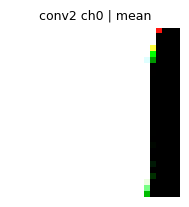

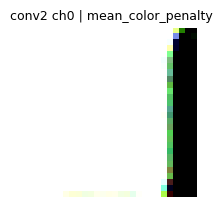

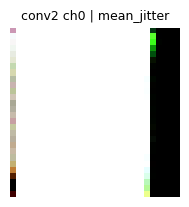

Polysemanticity images saved to: /home/bonda/Documents/precog_application/cv-task/experiments/task2/outputs/polysemanticity


In [9]:
# --- Polysemanticity experiment (same channel, different objectives) ---
poly_layer = "conv2"
poly_channel = 0
poly_dir = OUT_DIR / "polysemanticity"
poly_dir.mkdir(parents=True, exist_ok=True)

poly_specs = [
    {"name": "mean", "objective": "channel_mean", "color_penalty_weight": 0.0, "jitter_px": 0},
    {"name": "mean_color_penalty", "objective": "channel_mean_color_penalty", "color_penalty_weight": 1.0, "jitter_px": 0},
    {"name": "mean_jitter", "objective": "channel_mean", "color_penalty_weight": 0.0, "jitter_px": 2},
]

for spec in poly_specs:
    res = optimize_image(
        layer=poly_layer,
        channel=poly_channel,
        objective=spec["objective"],
        seed=0,
        color_penalty_weight=spec["color_penalty_weight"],
        jitter_px=spec["jitter_px"],
    )
    path = save_opt_image(res, poly_dir)
    show_image(res.image, title=f"{poly_layer} ch{poly_channel} | {spec['name']}")
    explore_log.append({
        "layer": poly_layer,
        "unit_type": "conv_channel",
        "unit_index": poly_channel,
        "objective": res.objective + f"_{spec['name']}",
        "regularization": res.regularization,
        "path": str(path),
        "observation": "",
        "interpretation": "",
    })

# Update log after polysemanticity runs
with (OUT_DIR / "explore_log.json").open("w") as f:
    json.dump(explore_log, f, indent=2)

print("Polysemanticity images saved to:", poly_dir)

## Summary (fill after running)

**Which layers focus on color?**
- _Your observations here_

**Evidence of shortcut learning (color vs shape):**
- _Your observations here_

**Clear examples of polysemantic neurons:**
- _Your observations here_

**Notes on early vs mid vs final conv:**
- `conv1` = early
- `conv2` = middle/final (only two conv layers)

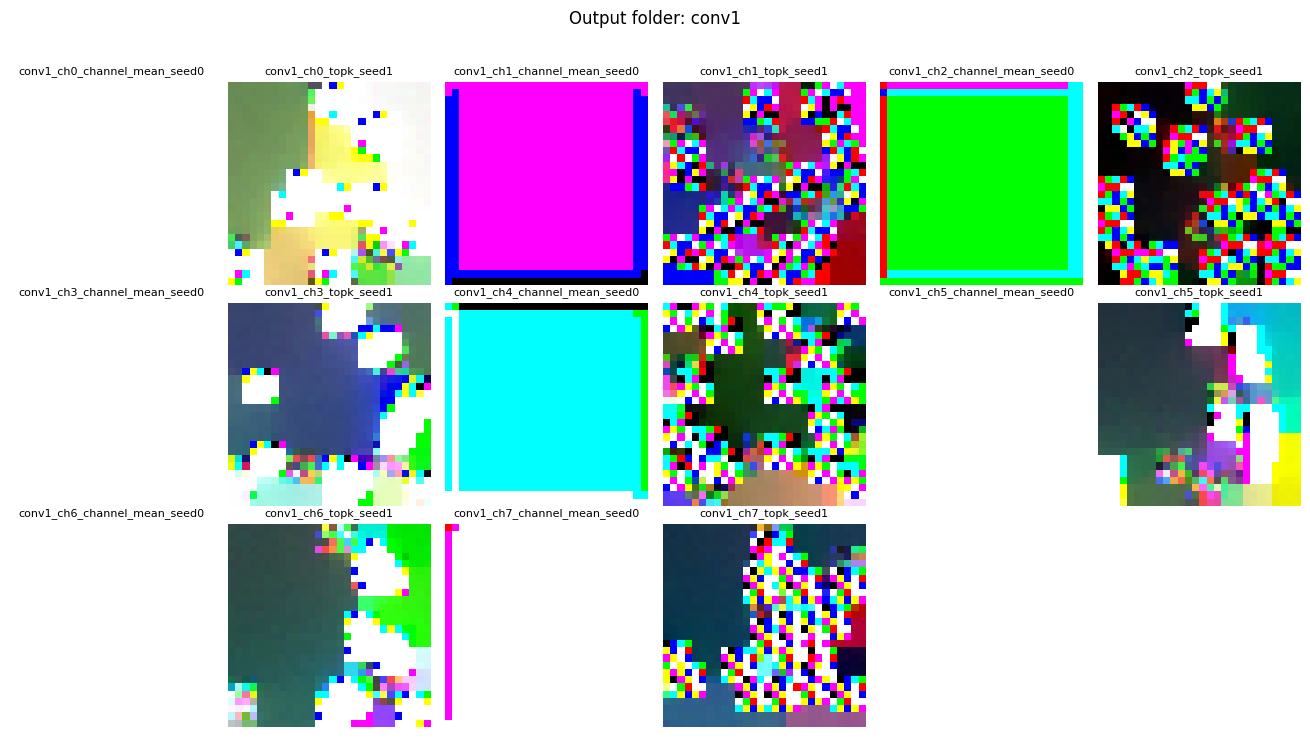

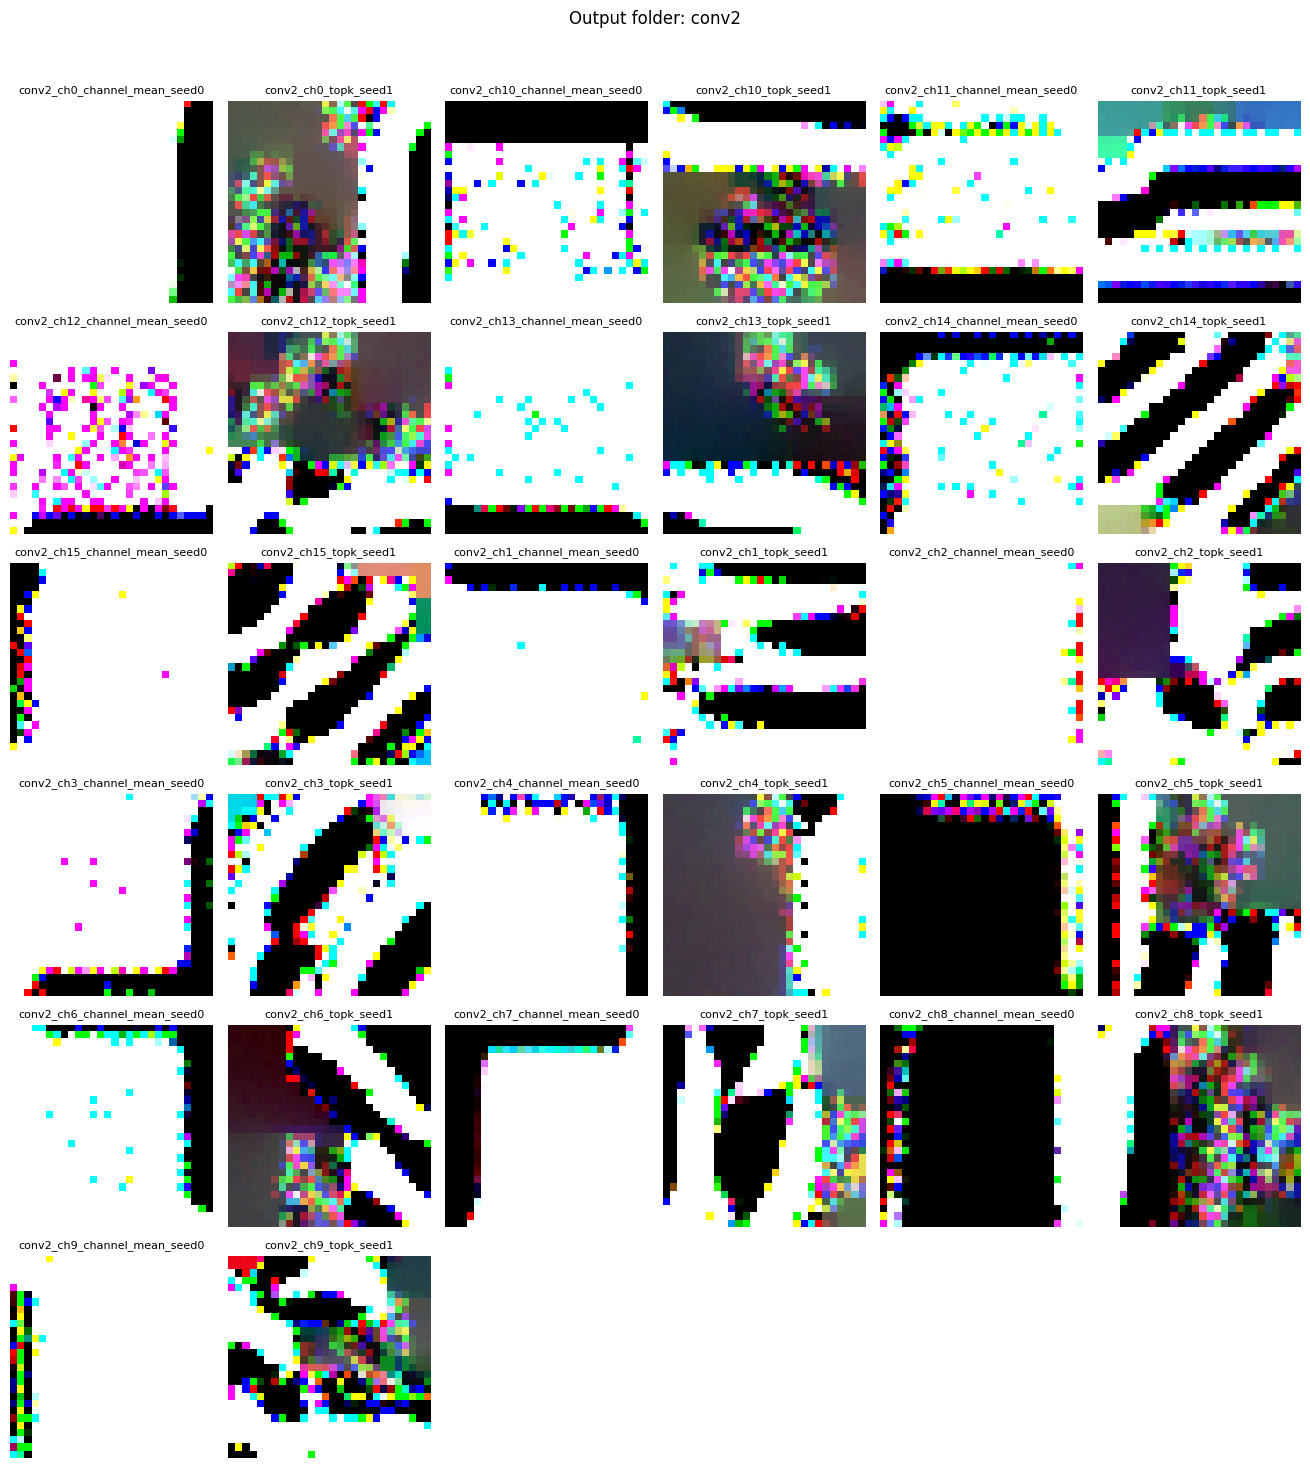

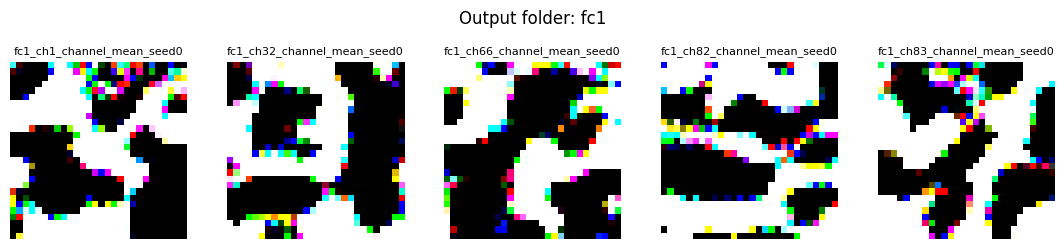

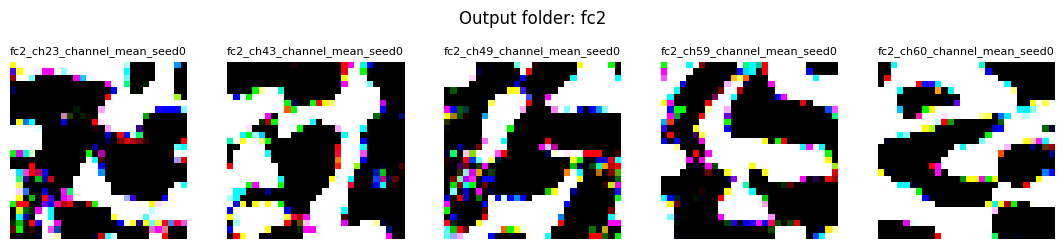

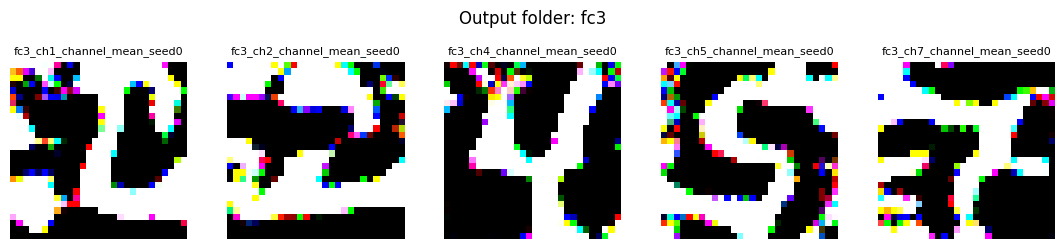

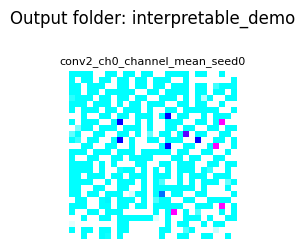

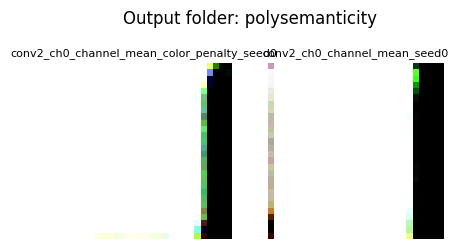

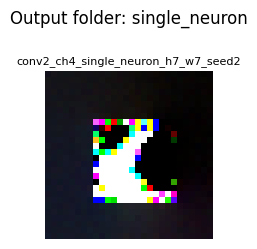

In [10]:
# --- Composite grids per output folder (captions included) ---
from PIL import Image

def _collect_image_paths(root: Path) -> List[Path]:
    return sorted([p for p in root.glob("*.png")])

def _show_grid_for_folder(folder: Path, max_cols: int = 6) -> None:
    image_paths = _collect_image_paths(folder)
    if not image_paths:
        print(f"No images found in: {folder}")
        return
    n = len(image_paths)
    cols = min(max_cols, n)
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(2.2 * cols, 2.4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])
    elif cols == 1:
        axes = np.array([[ax] for ax in axes])
    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i >= n:
            ax.axis("off")
            continue
        img_path = image_paths[i]
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(img_path.stem, fontsize=8)
        ax.axis("off")
    fig.suptitle(f"Output folder: {folder.relative_to(OUT_DIR)}", y=1.02)
    plt.tight_layout()
    plt.show()

# Iterate folders in outputs and render one grid per folder
for sub in sorted([p for p in OUT_DIR.iterdir() if p.is_dir()]):
    _show_grid_for_folder(sub, max_cols=6)

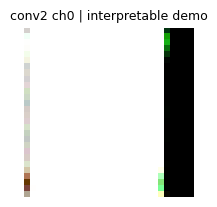

Saved demo image: /home/bonda/Documents/precog_application/cv-task/experiments/task2/outputs/interpretable_demo/conv2_ch0_channel_mean_seed0.png


In [11]:
# --- Interpretability-focused demo (stronger regularization) ---
demo_layer = "conv2"
demo_channel = 0
demo_dir = OUT_DIR / "interpretable_demo"
demo_dir.mkdir(parents=True, exist_ok=True)

demo_res = optimize_image(
    layer=demo_layer,
    channel=demo_channel,
    objective="channel_mean",
    seed=0,
    steps=400,
    lr=0.05,
    l2_weight=5e-4,
    tv_weight=5e-3,
    blur_weight=5e-2,
    blur_kernel=5,
    jitter_px=2,
)
demo_path = save_opt_image(demo_res, demo_dir)
show_image(demo_res.image, title=f"{demo_layer} ch{demo_channel} | interpretable demo")
print("Saved demo image:", demo_path)

Conv1 kernels shape: torch.Size([8, 3, 5, 5])


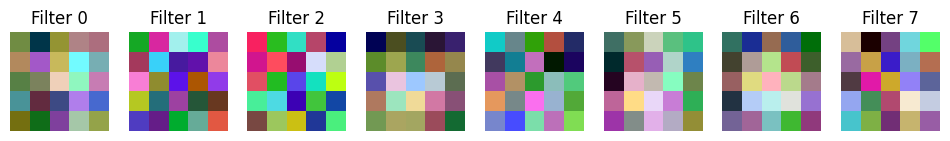

In [12]:
# --- Visualize Conv1 Kernels ---
# conv1 weights shape: (out_channels, in_channels, kH, kW) = (8, 3, 5, 5)
kernels = model.conv1.weight.detach().cpu()
print("Conv1 kernels shape:", kernels.shape)

fig, axes = plt.subplots(1, 8, figsize=(12, 3))
for i, ax in enumerate(axes):
    # Normalize to [0, 1] for display
    k = kernels[i] # (3, 5, 5)
    k = k - k.min()
    k = k / k.max()
    k = k.permute(1, 2, 0) # (5, 5, 3)
    ax.imshow(k)
    ax.axis("off")
    ax.set_title(f"Filter {i}")
plt.show()